# Splines in PyMC3

- [Question on PyMC Discourse](https://discourse.pymc.io/t/spline-regression-in-pymc3/6235)
- [*Statistical Rethinking* example in PyMC3](https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_04.ipynb)
- [*Statistical Rethinking* example in Stan](https://vincentarelbundock.github.io/rethinking2/04.html)

In [1]:
import string
import warnings
from pathlib import Path

import arviz as az
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import pymc3_helpers as pmhelp
import seaborn as sns
from patsy import dmatrix
from theano import tensor as tt

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_minimal())

RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)

pymc3_cache_dir = Path("pymc3_model_cache")
rethinking_data_path = Path("../data/rethinking_data")
modeling_data_path = Path("../modeling_data/depmap_modeling_dataframe_subsample.csv")

## Replicate the example from *Statistical Rethinking*

In [2]:
d = pd.read_csv(rethinking_data_path / "cherry_blossoms.csv")
# nans are not treated as in the book
az.summary(d.dropna().to_dict(orient="list"), kind="stats")

,mean,sd,hdi_3%,hdi_97%
year,1533.395,291.123,1016.00,1978.00
doy,104.921,6.258,92.00,115.00
temp,6.100,0.683,4.80,7.32
temp_upper,6.938,0.812,5.56,8.40
temp_lower,5.264,0.762,3.75,6.83


In [3]:
d2 = d.dropna(subset=["doy"])
num_knots = 15
knot_list = np.quantile(d2.year, np.linspace(0, 1, num_knots))
knot_list

array([ 812., 1036., 1174., 1269., 1377., 1454., 1518., 1583., 1650.,
       1714., 1774., 1833., 1893., 1956., 2015.])

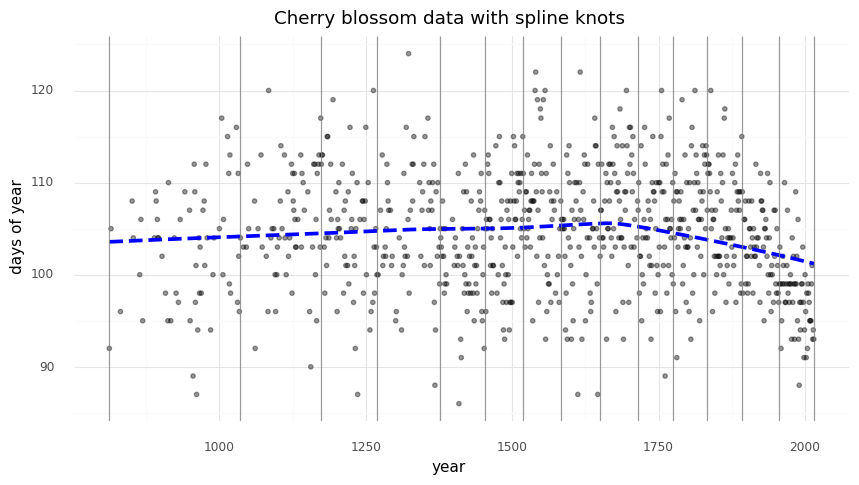

<ggplot: (8761418414809)>

In [4]:
(
    gg.ggplot(d2, gg.aes(x="year", y="doy"))
    + gg.geom_point(color="black", alpha=0.4, size=1.3)
    + gg.geom_smooth(size=1.5, color="blue", linetype="--")
    + gg.geom_vline(xintercept=knot_list, color="gray", alpha=0.8)
    + gg.theme(figure_size=(10, 5))
    + gg.labs(x="year", y="days of year", title="Cherry blossom data with spline knots")
)

In [5]:
B = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=True) - 1",
    {"year": d2.year.values, "knots": knot_list[1:-1]},
)
B

DesignMatrix with shape (827, 17)
  Columns:
    ['bs(year, knots=knots, degree=3, include_intercept=True)[0]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[1]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[2]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[3]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[4]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[5]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[6]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[7]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[8]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[9]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[10]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[11]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[12]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[13]',
     'bs(year

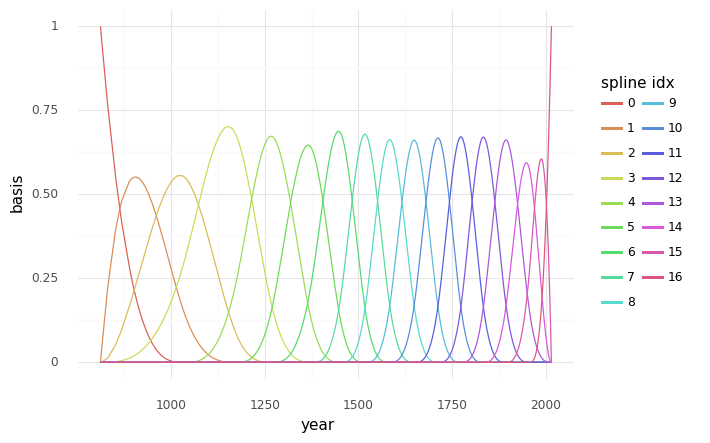

<ggplot: (8761417822952)>

In [6]:
spline_df = (
    pd.DataFrame(B)
    .assign(year=d2.year.values)
    .melt("year", var_name="spline_i", value_name="value")
)

(
    gg.ggplot(spline_df, gg.aes(x="year", y="value"))
    + gg.geom_line(gg.aes(group="spline_i", color="spline_i"))
    + gg.scale_color_discrete(guide=gg.guide_legend(ncol=2))
    + gg.labs(x="year", y="basis", color="spline idx")
)

In [7]:
with pm.Model() as m4_7:
    a = pm.Normal("a", 100, 10)
    w = pm.Normal("w", mu=0, sd=10, shape=B.shape[1])
    mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(B, order="F"), w.T))
    # mu = pm.Deterministic("mu", a + pm.math.dot(B.base, w.T))
    sigma = pm.Exponential("sigma", 1)
    D = pm.Normal("D", mu, sigma, observed=d2.doy)

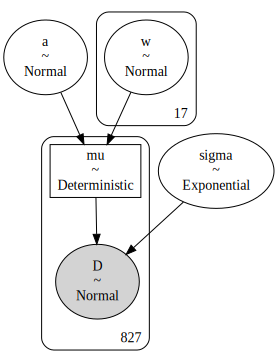

In [8]:
pm.model_to_graphviz(m4_7)

In [9]:
with m4_7:
    prior_pc = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    trace_m4_7 = pm.sample(1000, random_seed=RANDOM_SEED)
    post_pc = pm.sample_posterior_predictive(trace_m4_7, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, w, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [10]:
az_m4_7 = az.from_pymc3(
    model=m4_7, trace=trace_m4_7, posterior_predictive=post_pc, prior=prior_pc
)

In [11]:
az.summary(az_m4_7, var_names=["a", "w", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,103.237,2.268,99.101,107.487,0.091,0.064,621.0,621.0,621.0,966.0,1.01
w[0],-2.903,3.841,-9.623,5.025,0.095,0.067,1645.0,1645.0,1645.0,2344.0,1.00
w[1],-0.729,3.863,-7.989,6.467,0.108,0.077,1273.0,1273.0,1271.0,2138.0,1.00
w[2],-0.925,3.481,-7.529,5.277,0.099,0.070,1240.0,1240.0,1241.0,2124.0,1.00
w[3],4.944,2.806,-0.533,9.991,0.097,0.069,832.0,832.0,832.0,1333.0,1.01
w[4],-0.738,2.779,-5.865,4.453,0.091,0.064,932.0,932.0,932.0,1905.0,1.01
w[5],4.428,2.880,-0.988,9.773,0.096,0.068,906.0,906.0,907.0,1520.0,1.01
w[6],-5.201,2.745,-10.194,0.182,0.093,0.066,869.0,869.0,869.0,1770.0,1.01
w[7],7.970,2.744,2.772,13.109,0.094,0.066,861.0,861.0,860.0,1537.0,1.01
w[8],-0.877,2.800,-6.032,4.380,0.095,0.067,865.0,865.0,864.0,1791.0,1.00


In [23]:
post_pred = az.summary(az_m4_7, var_names=["mu"]).reset_index()
d2_post = d2.copy().reset_index(drop=True)
d2_post["pred_mean"] = post_pred["mean"]
d2_post["pred_hdi_lower"] = post_pred["hdi_3%"]
d2_post["pred_hdi_upper"] = post_pred["hdi_97%"]

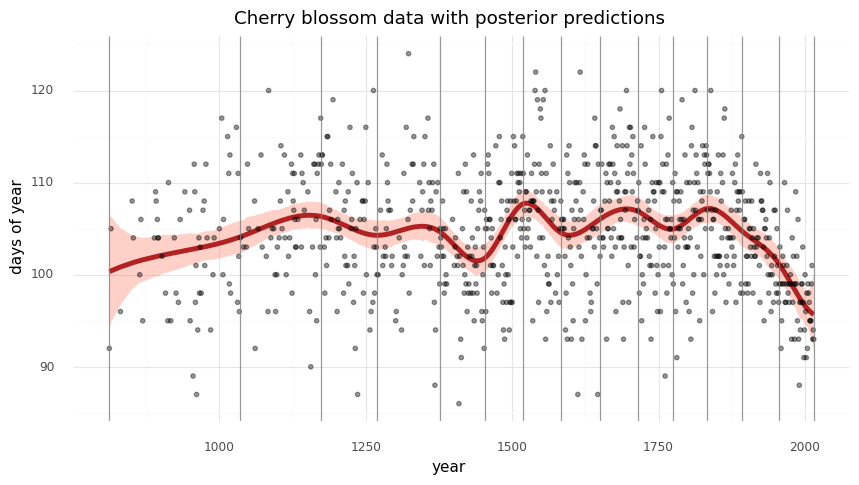

<ggplot: (8761384712611)>

In [24]:
(
    gg.ggplot(d2_post, gg.aes(x="year"))
    + gg.geom_ribbon(
        gg.aes(ymin="pred_hdi_lower", ymax="pred_hdi_upper"), alpha=0.3, fill="tomato"
    )
    + gg.geom_line(gg.aes(y="pred_mean"), color="firebrick", alpha=1, size=2)
    + gg.geom_point(gg.aes(y="doy"), color="black", alpha=0.4, size=1.3)
    + gg.geom_vline(xintercept=knot_list, color="gray", alpha=0.8)
    + gg.theme(figure_size=(10, 5))
    + gg.labs(
        x="year",
        y="days of year",
        title="Cherry blossom data with posterior predictions",
    )
)

## Example with gene CN data of a single gene

In [25]:
modeling_data = pd.read_csv(modeling_data_path)
modeling_data

,sgrna,replicate_id,lfc,pdna_batch,passes_qc,depmap_id,primary_or_metastasis,lineage,lineage_subtype,kras_mutation,...,log2_gene_cn_p1,gene_cn,n_muts,any_deleterious,variant_classification,is_deleterious,is_tcga_hotspot,is_cosmic_hotspot,mutated_at_guide_location,rna_expr
0,AAGAGGCCGGTCAAATTCAG,42-mg-ba-311cas9_repa_p6_batch3,-0.405499,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.845287,1.328646,0,False,NaN,NaN,NaN,NaN,False,1.263034
1,AATCAACCCACAGCTGCACA,42-mg-ba-311cas9_repa_p6_batch3,-0.133541,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.827398,1.287359,2,False,missense_mutation;missense_mutation,FALSE;FALSE,TRUE;TRUE,TRUE;TRUE,False,5.220330
2,AATTACTACTTGCTTCCTGT,42-mg-ba-311cas9_repa_p6_batch3,-0.491495,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.879280,1.409165,0,False,NaN,NaN,NaN,NaN,False,3.008989
3,ACCTGTATGACGAAACCGTG,42-mg-ba-311cas9_repa_p6_batch3,-0.015850,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.818549,1.267208,0,False,NaN,NaN,NaN,NaN,False,4.083213
4,ACTCTGTTCCTTCATCTCCG,42-mg-ba-311cas9_repa_p6_batch3,-0.530277,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.990378,1.692253,0,False,NaN,NaN,NaN,NaN,False,5.822730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60044,TTATTAATGTAGCCTCACGG,ykg1-311cas9_repb_p6_batch3,-0.096160,3,True,ACH-000570,Primary,central_nervous_system,glioma,WT,...,1.129110,2.092901,1,False,missense_mutation,FALSE,TRUE,TRUE,False,3.792855
60045,TTCCGTTTATCATGAAGCCG,ykg1-311cas9_repb_p6_batch3,-0.975325,3,True,ACH-000570,Primary,central_nervous_system,glioma,WT,...,1.129110,2.092901,0,False,NaN,NaN,NaN,NaN,False,6.134426
60046,TTGCAATGTGATGGAAGGGG,ykg1-311cas9_repb_p6_batch3,0.408497,3,True,ACH-000570,Primary,central_nervous_system,glioma,WT,...,0.950623,1.587322,0,False,NaN,NaN,NaN,NaN,False,3.645010
60047,TTGTCCCAGCCGTCAAACCG,ykg1-311cas9_repb_p6_batch3,-0.050832,3,True,ACH-000570,Primary,central_nervous_system,glioma,WT,...,1.071891,1.920898,0,False,NaN,NaN,NaN,NaN,False,0.992768


### A "well-behaved" gene: *PTK2*

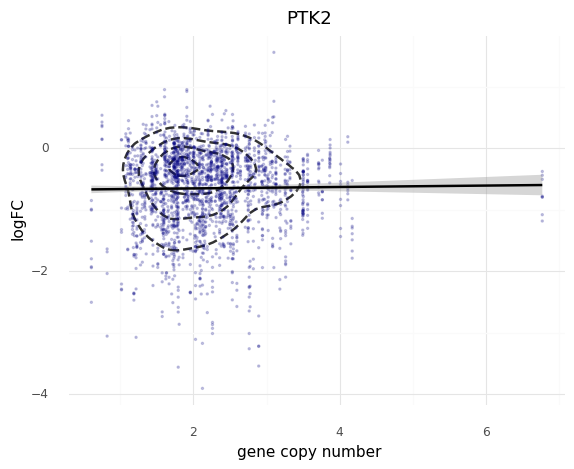

<ggplot: (8761379076648)>

In [165]:
np.random.seed(RANDOM_SEED)
ptk2_data = modeling_data[modeling_data.hugo_symbol == "PTK2"]

(
    gg.ggplot(ptk2_data, gg.aes(x="gene_cn", y="lfc"))
    + gg.geom_density_2d(color="black", alpha=0.8, size=1, linetype="--")
    + gg.geom_point(size=0.4, alpha=0.2, color="navy")
    + gg.geom_smooth(method="lm")
    + gg.labs(x="gene copy number", y="logFC", title="PTK2")
)

In [166]:
ptk2_data.shape[0]

2332

In [167]:
cn_num_knots = 5
cn_knot_list = np.quantile(ptk2_data.gene_cn, np.linspace(0, 1, cn_num_knots))

ptk2_B = dmatrix(
    "bs(x, knots=knots, degree=3, include_intercept=True) - 1",
    {"x": ptk2_data.gene_cn, "knots": cn_knot_list[1:-1]},
)

print(cn_knot_list)

[0.60396783 1.67270427 2.08756486 2.53427991 6.7709577 ]


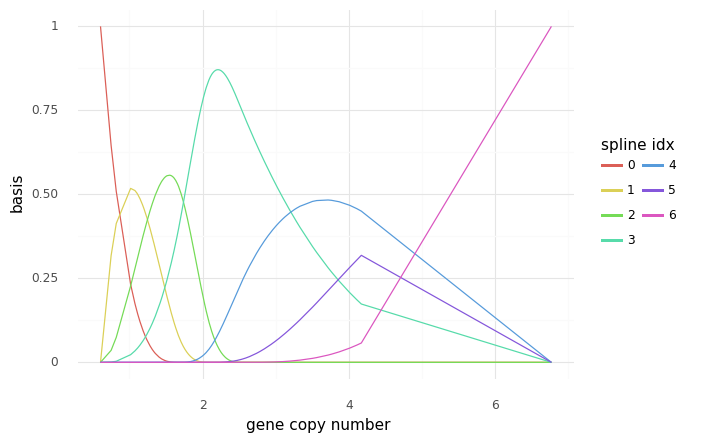

<ggplot: (8761379518784)>

In [168]:
ptk2_spline_df = (
    pd.DataFrame(ptk2_B)
    .assign(gene_cn=ptk2_data.gene_cn.values)
    .melt("gene_cn", var_name="spline_i", value_name="value")
)

(
    gg.ggplot(ptk2_spline_df, gg.aes(x="gene_cn", y="value"))
    + gg.geom_line(gg.aes(group="spline_i", color="spline_i"))
    + gg.scale_color_discrete(guide=gg.guide_legend(ncol=2))
    + gg.labs(x="gene copy number", y="basis", color="spline idx")
)

In [169]:
with pm.Model() as m_ptk2:
    a = pm.Normal("a", mu=0, sd=5)
    w = pm.Normal("w", mu=0, sd=2, shape=ptk2_B.shape[1])
    mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(ptk2_B, order="F"), w.T))
    # mu = pm.Deterministic("mu", a + pm.math.dot(ptk2_B.base, w.T))
    sigma = pm.Exponential("sigma", 1)
    D = pm.Normal("D", mu, sigma, observed=ptk2_data.lfc)

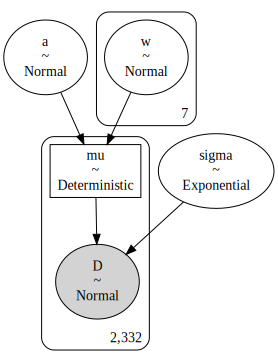

In [170]:
pm.model_to_graphviz(m_ptk2)

In [171]:
with m_ptk2:
    prior_pc = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    trace_m_ptk2 = pm.sample(1000, random_seed=RANDOM_SEED)
    post_pc = pm.sample_posterior_predictive(trace_m_ptk2, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, w, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
The acceptance probability does not match the target. It is 0.881635488786398, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [172]:
az_ptk2 = az.from_pymc3(
    model=m_ptk2, trace=trace_m_ptk2, posterior_predictive=post_pc, prior=prior_pc
)

In [173]:
post_pred = az.summary(az_ptk2, var_names=["mu"]).reset_index(drop=True)
ptk2_post = ptk2_data.copy().reset_index(drop=True)
ptk2_post["pred_mean"] = post_pred["mean"]
ptk2_post["pred_hdi_lower"] = post_pred["hdi_3%"]
ptk2_post["pred_hdi_upper"] = post_pred["hdi_97%"]
ptk2_post.head()

,sgrna,replicate_id,lfc,pdna_batch,passes_qc,depmap_id,primary_or_metastasis,lineage,lineage_subtype,kras_mutation,...,any_deleterious,variant_classification,is_deleterious,is_tcga_hotspot,is_cosmic_hotspot,mutated_at_guide_location,rna_expr,pred_mean,pred_hdi_lower,pred_hdi_upper
0,ATATGGCTGACCTAATAGAT,42-mg-ba-311cas9_repa_p6_batch3,-0.723507,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,False,NaN,NaN,NaN,NaN,False,5.878235,-0.645,-0.686,-0.606
1,CGATCATACTGGGAGATGCG,42-mg-ba-311cas9_repa_p6_batch3,-0.445568,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,False,NaN,NaN,NaN,NaN,False,5.878235,-0.645,-0.686,-0.606
2,GCGAGGTTCCATTCACCAGC,42-mg-ba-311cas9_repa_p6_batch3,-0.429098,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,False,NaN,NaN,NaN,NaN,False,5.878235,-0.645,-0.686,-0.606
3,GGAGGTTCACTGGCTTCACG,42-mg-ba-311cas9_repa_p6_batch3,-0.485250,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,False,NaN,NaN,NaN,NaN,False,5.878235,-0.645,-0.686,-0.606
4,ATATGGCTGACCTAATAGAT,42-mg-ba-311cas9_repb_p6_batch3,-0.889930,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,False,NaN,NaN,NaN,NaN,False,5.878235,-0.645,-0.686,-0.606


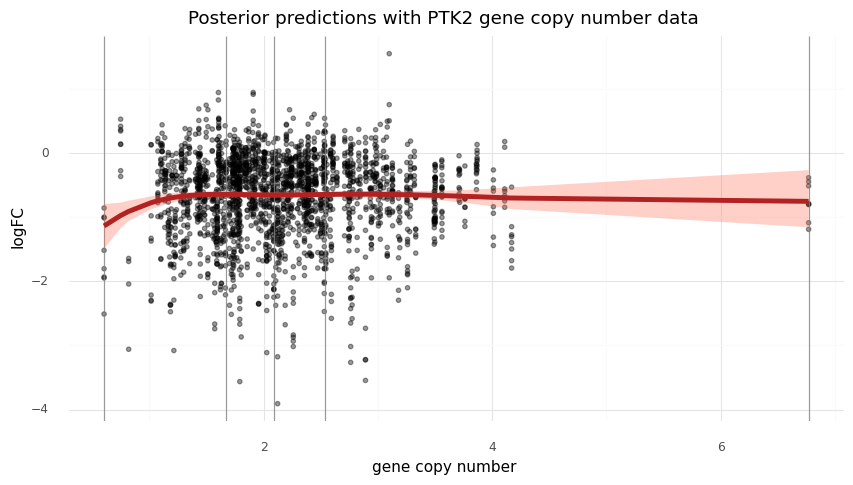

<ggplot: (8761381506030)>

In [174]:
(
    gg.ggplot(ptk2_post, gg.aes(x="gene_cn"))
    + gg.geom_point(gg.aes(y="lfc"), color="black", alpha=0.4, size=1.3)
    + gg.geom_vline(xintercept=cn_knot_list, color="gray", alpha=0.8)
    + gg.geom_ribbon(
        gg.aes(ymin="pred_hdi_lower", ymax="pred_hdi_upper"), alpha=0.3, fill="tomato"
    )
    + gg.geom_line(gg.aes(y="pred_mean"), color="firebrick", alpha=1, size=2)
    + gg.theme(figure_size=(10, 5))
    + gg.labs(
        x="gene copy number",
        y="logFC",
        title="Posterior predictions with PTK2 gene copy number data",
    )
)

### A "misbehaved" gene: *MDM2*

In the original Meyers *et al.* (2017) paper, the spline function for each cell line was created with 25 slope coefficients.
The first was automatically pinned to copy number = 0 and the rest were determed using average linkage clustering (a form a hierarhcical clustering) of copy number data for each cell line.
I want to mimic this effect here, but will use the copy number data of all of the genes in the modeling data sub-sample to determine the knots and then fit the model with the data from *MDM2*, a gene was some strong extemes for copy number.

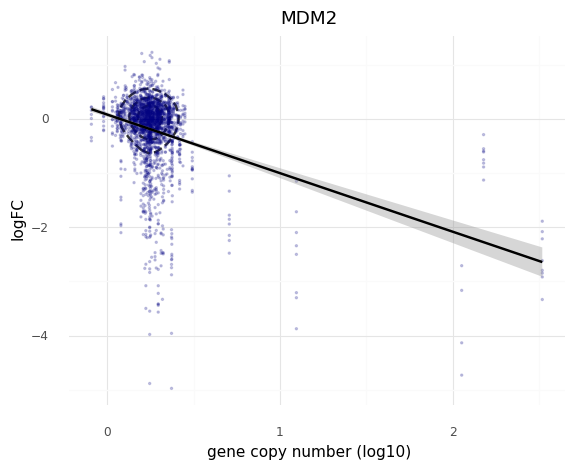

<ggplot: (8761372111357)>

In [184]:
np.random.seed(RANDOM_SEED)
mdm2_data = modeling_data.copy()[modeling_data.hugo_symbol == "MDM2"]
mdm2_data["log_gene_cn"] = np.log10(mdm2_data.gene_cn.values)
(
    gg.ggplot(mdm2_data, gg.aes(x="log_gene_cn", y="lfc"))
    + gg.geom_density_2d(color="black", alpha=0.8, size=1, linetype="--")
    + gg.geom_point(size=0.4, alpha=0.2, color="navy")
    + gg.geom_smooth(method="lm")
    + gg.labs(x="gene copy number (log10)", y="logFC", title="MDM2")
)

In [185]:
mdm2_data.shape[0]

2332

In [202]:
cn_num_knots = 5
gene_cn_data = (
    modeling_data[["depmap_id", "hugo_symbol", "gene_cn"]]
    .drop_duplicates()
    .reset_index(drop=True)
)
cn_knot_list = np.quantile(gene_cn_data.gene_cn, np.linspace(0, 1, cn_num_knots))

mdm2_B = dmatrix(
    "bs(x, knots=knots, degree=3, include_intercept=True) - 1",
    {"x": mdm2_data.gene_cn, "knots": cn_knot_list[1:-1]},
)

print([np.round(a, 2) for a in cn_knot_list])

[0.0, 1.44, 1.73, 2.03, 328.39]


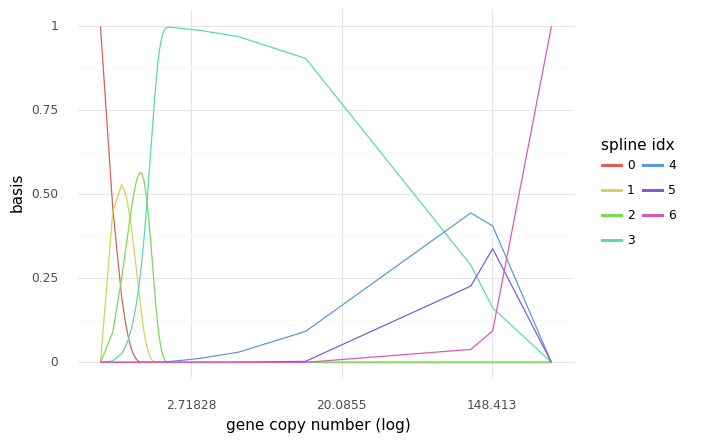

<ggplot: (8761383551979)>

In [203]:
mdm2_spline_df = (
    pd.DataFrame(mdm2_B)
    .assign(gene_cn=mdm2_data.gene_cn.values)
    .melt("gene_cn", var_name="spline_i", value_name="value")
)

(
    gg.ggplot(mdm2_spline_df, gg.aes(x="gene_cn", y="value"))
    + gg.geom_line(gg.aes(group="spline_i", color="spline_i"))
    + gg.scale_color_discrete(guide=gg.guide_legend(ncol=2))
    + gg.scale_x_continuous(trans="log")
    + gg.labs(x="gene copy number (log)", y="basis", color="spline idx")
)

In [204]:
with pm.Model() as m_mdm2:
    a = pm.Normal("a", mu=0, sd=5)
    w = pm.Normal("w", mu=0, sd=2, shape=mdm2_B.shape[1])
    mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(mdm2_B, order="F"), w.T))
    sigma = pm.Exponential("sigma", 1)
    D = pm.Normal("D", mu, sigma, observed=mdm2_data.lfc)

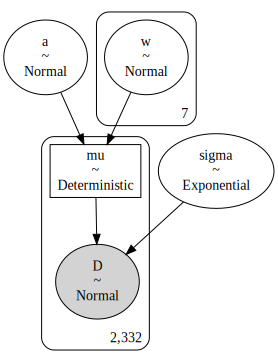

In [205]:
pm.model_to_graphviz(m_mdm2)

In [206]:
with m_mdm2:
    prior_pc = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    trace_m_mdm2 = pm.sample(1000, random_seed=RANDOM_SEED)
    post_pc = pm.sample_posterior_predictive(trace_m_mdm2, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, w, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.
The acceptance probability does not match the target. It is 0.8807772574577065, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [207]:
az_mdm2 = az.from_pymc3(
    model=m_mdm2, trace=trace_m_mdm2, posterior_predictive=post_pc, prior=prior_pc
)

In [208]:
post_pred = az.summary(az_mdm2, var_names=["mu"]).reset_index(drop=True)
mdm2_post = mdm2_data.copy().reset_index(drop=True)
mdm2_post["pred_mean"] = post_pred["mean"]
mdm2_post["pred_hdi_lower"] = post_pred["hdi_3%"]
mdm2_post["pred_hdi_upper"] = post_pred["hdi_97%"]
mdm2_post.head()

,sgrna,replicate_id,lfc,pdna_batch,passes_qc,depmap_id,primary_or_metastasis,lineage,lineage_subtype,kras_mutation,...,variant_classification,is_deleterious,is_tcga_hotspot,is_cosmic_hotspot,mutated_at_guide_location,rna_expr,log_gene_cn,pred_mean,pred_hdi_lower,pred_hdi_upper
0,AGACACTTATACTATGAAAG,42-mg-ba-311cas9_repa_p6_batch3,0.035950,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,NaN,NaN,NaN,NaN,False,3.701549,0.143784,-0.002,-0.055,0.056
1,AGTTACTGTGTATCAGGCAG,42-mg-ba-311cas9_repa_p6_batch3,0.059690,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,NaN,NaN,NaN,NaN,False,3.701549,0.143784,-0.002,-0.055,0.056
2,GTTCTTGTCCTTCTTCACTA,42-mg-ba-311cas9_repa_p6_batch3,0.148150,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,NaN,NaN,NaN,NaN,False,3.701549,0.143784,-0.002,-0.055,0.056
3,TTGCAATGTGATGGAAGGGG,42-mg-ba-311cas9_repa_p6_batch3,-0.102953,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,NaN,NaN,NaN,NaN,False,3.701549,0.143784,-0.002,-0.055,0.056
4,AGACACTTATACTATGAAAG,42-mg-ba-311cas9_repb_p6_batch3,-0.469799,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,NaN,NaN,NaN,NaN,False,3.701549,0.143784,-0.002,-0.055,0.056


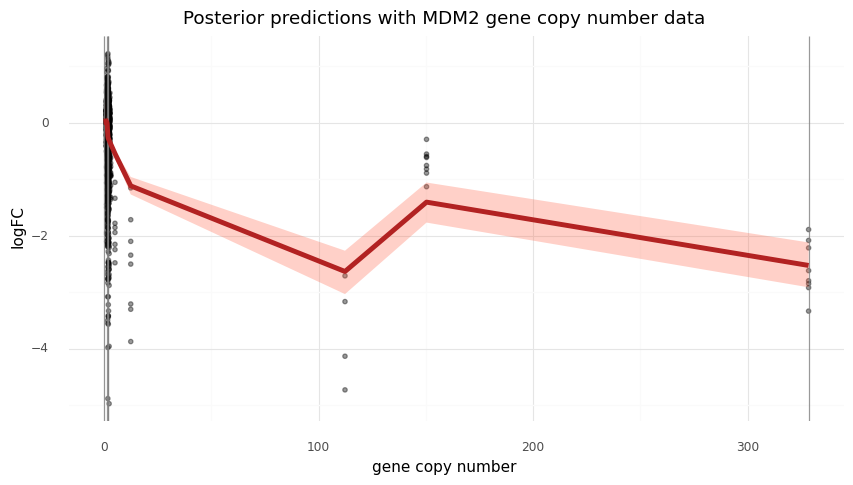

<ggplot: (8761379277876)>

In [213]:
(
    gg.ggplot(mdm2_post, gg.aes(x="gene_cn"))
    + gg.geom_point(gg.aes(y="lfc"), color="black", alpha=0.4, size=1.3)
    + gg.geom_vline(xintercept=cn_knot_list, color="gray", alpha=0.8)
    + gg.geom_ribbon(
        gg.aes(ymin="pred_hdi_lower", ymax="pred_hdi_upper"), alpha=0.3, fill="tomato"
    )
    + gg.geom_line(gg.aes(y="pred_mean"), color="firebrick", alpha=1, size=2)
    + gg.theme(figure_size=(10, 5))
    + gg.scale_x_continuous()
    + gg.labs(
        x="gene copy number",
        y="logFC",
        title="Posterior predictions with MDM2 gene copy number data",
    )
)

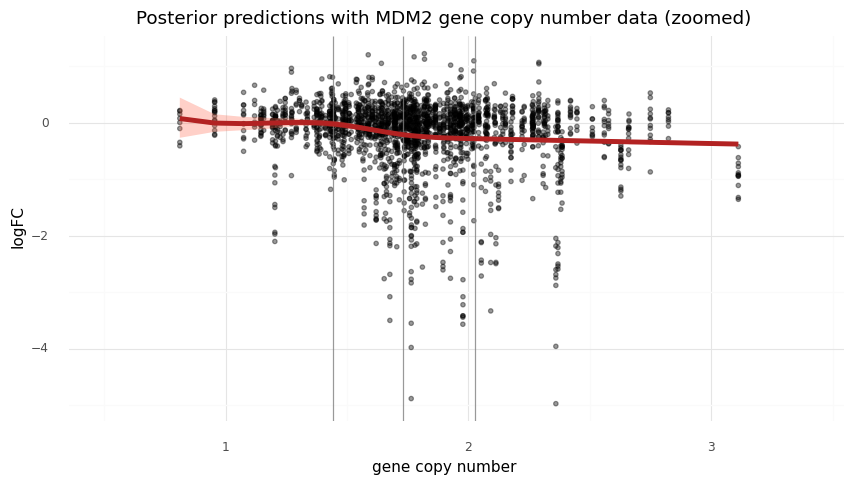

<ggplot: (8761380914755)>

In [217]:
(
    gg.ggplot(mdm2_post, gg.aes(x="gene_cn"))
    + gg.geom_point(gg.aes(y="lfc"), color="black", alpha=0.4, size=1.3)
    + gg.geom_vline(xintercept=cn_knot_list, color="gray", alpha=0.8)
    + gg.geom_ribbon(
        gg.aes(ymin="pred_hdi_lower", ymax="pred_hdi_upper"), alpha=0.3, fill="tomato"
    )
    + gg.geom_line(gg.aes(y="pred_mean"), color="firebrick", alpha=1, size=2)
    + gg.theme(figure_size=(10, 5))
    + gg.scale_x_continuous(limits=(0.5, 3.4))
    + gg.labs(
        x="gene copy number",
        y="logFC",
        title="Posterior predictions with MDM2 gene copy number data (zoomed)",
    )
)

### Multi-level

How to do this with multiple levels?
The original 2017 paper created a spline function for each cell line.
I think the only change would be to have an additional index on `w` and keep all of the `B` matrices in a list that gets indexed, too.

In [25]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

plotnine 0.7.1
pandas   1.1.3
arviz    0.10.0
pymc3    3.9.3
numpy    1.19.2
seaborn  0.11.0
last updated: 2020-11-13 

CPython 3.8.5
IPython 7.18.1

compiler   : GCC 7.3.0
system     : Linux
release    : 3.10.0-1062.el7.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 28
interpreter: 64bit
host name  : compute-e-16-229.o2.rc.hms.harvard.edu
Git branch : subset-data
